# Brain Stroke Prediction

## Importing Necessary Libraries

In [114]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as SSSplit
from imblearn.ensemble import BalancedBaggingClassifier
from scipy.integrate import simps
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV

In [115]:
if os.path.exists('brain_stroke.csv'):
    print("Alreday Present")
else:
    !wget https://www.dropbox.com/s/fpymf1avgdhx31i/brain_stroke.csv

Alreday Present


## Data Visualization

In [116]:
df=pd.read_csv('brain_stroke.csv')

In [117]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [118]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [119]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [120]:
for col in df.columns:
    print("column:  {:18s} |    unique element cnt: {}".format(col, len(np.unique(df[col]))))

column:  gender             |    unique element cnt: 2
column:  age                |    unique element cnt: 104
column:  hypertension       |    unique element cnt: 2
column:  heart_disease      |    unique element cnt: 2
column:  ever_married       |    unique element cnt: 2
column:  work_type          |    unique element cnt: 4
column:  Residence_type     |    unique element cnt: 2
column:  avg_glucose_level  |    unique element cnt: 3895
column:  bmi                |    unique element cnt: 342
column:  smoking_status     |    unique element cnt: 4
column:  stroke             |    unique element cnt: 2


In [121]:
col_to_encode=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in col_to_encode:
    encoder=LabelEncoder()
    df[i]=encoder.fit_transform(df[i])
    print(f"{i} encoding: {dict(zip(encoder.classes_, range(len(encoder.classes_))))}")

gender encoding: {'Female': 0, 'Male': 1}
ever_married encoding: {'No': 0, 'Yes': 1}
work_type encoding: {'Govt_job': 0, 'Private': 1, 'Self-employed': 2, 'children': 3}
Residence_type encoding: {'Rural': 0, 'Urban': 1}
smoking_status encoding: {'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}


In [122]:
df.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,0.416382,43.419859,0.096165,0.055210,0.658502,1.302349,0.508332,105.943562,28.498173,1.379442,0.049789
std,0.493008,22.662755,0.294848,0.228412,0.474260,0.860170,0.499981,45.075373,6.790464,1.072180,0.217531
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,14.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,77.230000,23.700000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,1.000000,91.850000,28.100000,2.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,2.000000,1.000000,113.860000,32.600000,2.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,3.000000,1.000000,271.740000,48.900000,3.000000,1.000000


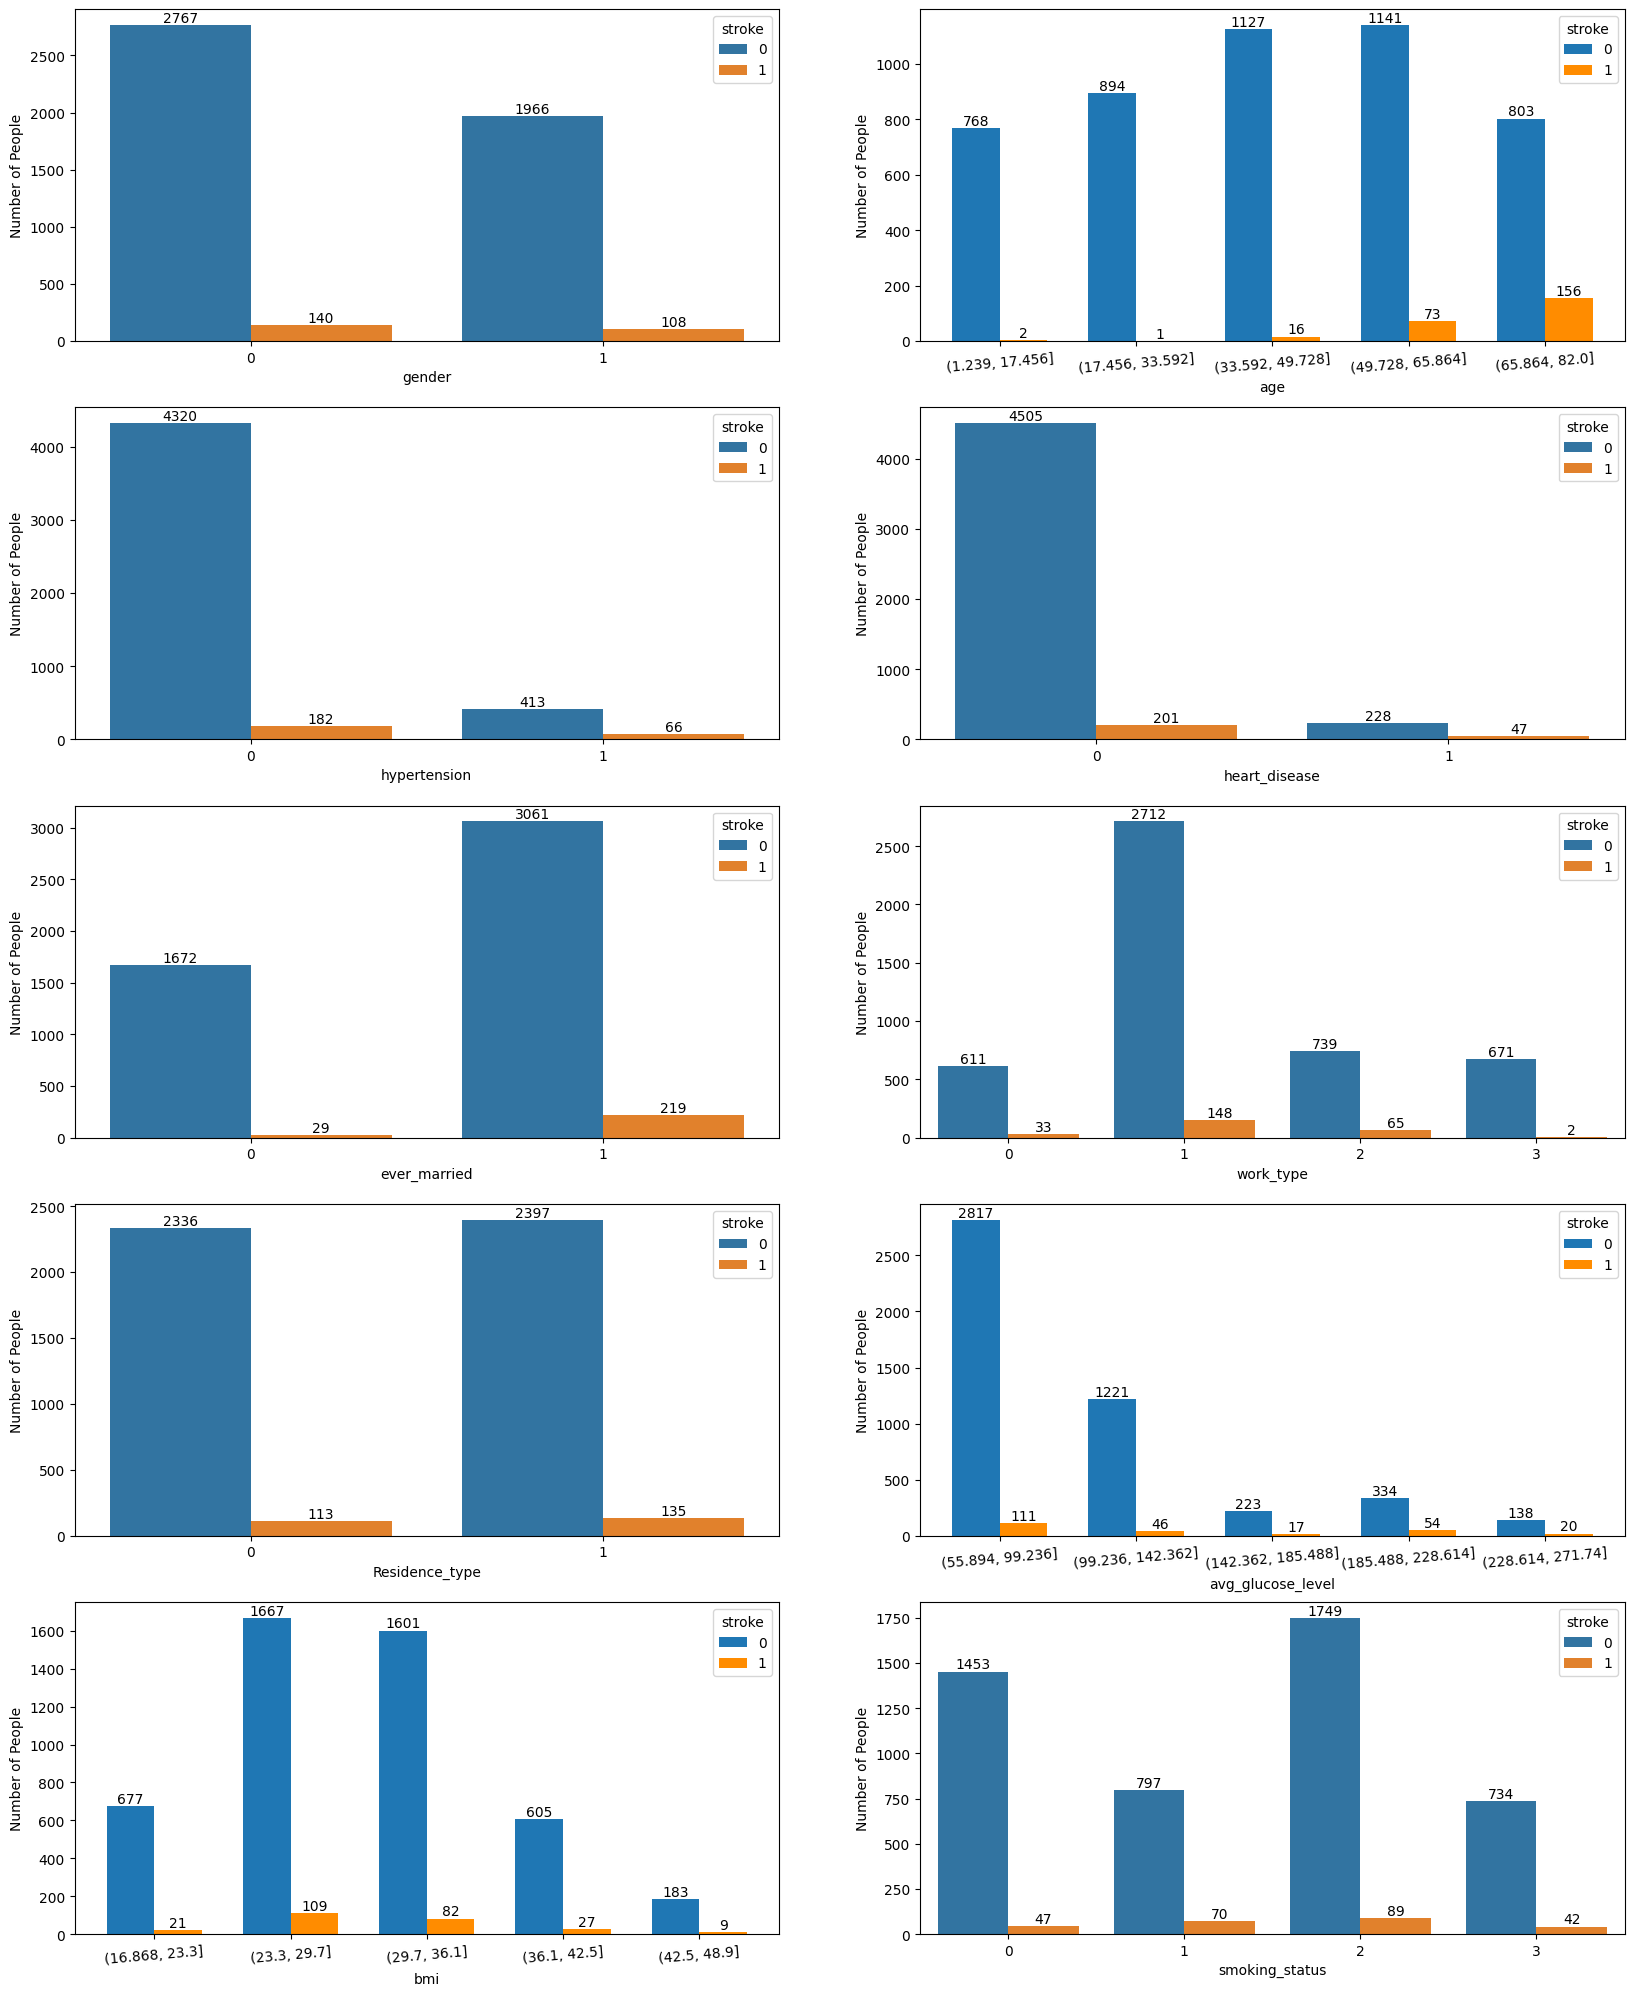

In [123]:
fig = plt.figure(figsize=(20, 25))
cnt = 0
temp = df
for i in df.columns[:-1]:
    if i in ["age", "avg_glucose_level", "bmi"]:
        cnt += 1
        ax = fig.add_subplot(5, 2, cnt)
        plt.xlabel(i)
        plt.ylabel("Number of People")
        bin_counts_1 = pd.cut(temp[i][temp["stroke"] == 1], bins=5).value_counts().sort_index()
        bin_counts_0 = pd.cut(temp[i][temp["stroke"] == 0], bins=5).value_counts().sort_index()
        bar_width = 0.35
        x_labels = bin_counts_1.index.values.astype(str)
        x = np.arange(len(x_labels))
        ax.bar(x - bar_width/2, bin_counts_0.values, width=bar_width, label="0",alpha = 1.0)
        ax.bar(x + bar_width/2, bin_counts_1.values, width=bar_width, label="1", color='darkorange',alpha = 1.0)
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=5)
        for j, v2, v1 in zip(x, bin_counts_1.values, bin_counts_0.values):
            ax.annotate(str(v1), xy=(j - bar_width/2, v1), ha='center', va='bottom', color='black')
            ax.annotate(str(v2), xy=(j + bar_width/2, v2), ha='center', va='bottom', color='black')
        plt.legend(title = "stroke")
    else:
        cnt += 1
        ax = fig.add_subplot(5, 2, cnt)
        sns.countplot(data=temp, x=i, hue="stroke", ax=ax)
        plt.xlabel(i)
        plt.ylabel("Number of People")
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

In [124]:
#Scalling the dataset
scaler = MinMaxScaler()
for col in df.columns:
    if(col!='stroke'):
        df[col] = scaler.fit_transform(np.array(df[col]).reshape(len(df[col]),1))

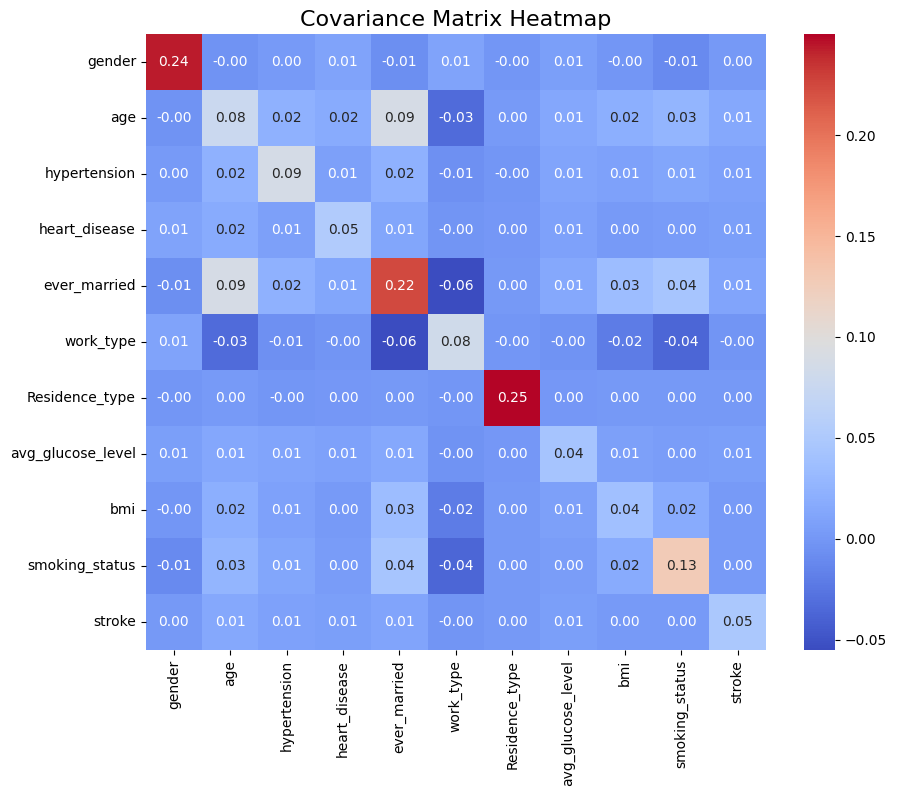

In [125]:
cov_matrix=df.cov()
plt.figure(figsize=(10, 8)) 
sns.heatmap(cov_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Covariance Matrix Heatmap', fontsize=16)

# Show plot
plt.show()

In [126]:
X=df.drop('stroke',axis=1).to_numpy()
y=df['stroke'].to_numpy()



In [127]:

X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,stratify=y)
print(X_train.shape,X_test.shape)
X_train_not_sampled,y_train_not_sampled=X_train,y_train

(3486, 10) (1495, 10)


In [128]:
smk = SMOTETomek(sampling_strategy='minority', random_state=42)
X_train, y_train = smk.fit_resample(X_train, y_train)
print(X_train)
print("After Oversampling:")
print("Risk", Counter(y_train))

[[0.         0.76806641 1.         ... 0.12196473 0.29226361 0.66666667]
 [0.         0.86572266 1.         ... 0.23280399 0.4756447  1.        ]
 [1.         0.29199219 0.         ... 0.25948666 0.4469914  0.33333333]
 ...
 [0.         0.67817768 0.         ... 0.25437759 0.37613934 0.66666667]
 [1.         0.93920914 1.         ... 0.60543283 0.51776448 0.66666667]
 [0.         0.94373841 0.         ... 0.20674136 0.53939554 0.66666667]]
After Oversampling:
Risk Counter({0: 3286, 1: 3286})


In [129]:
len(X_train)

6572

## Selecting essential features using PCA

In [130]:
#98% variance explained

pca = PCA()
pca.fit(df.drop("stroke",axis = 1))

# Get principal components
pcs = pca.transform(df.drop("stroke",axis = 1))
pc_df = pd.DataFrame(pcs, columns=['PC{}'.format(i) for i in range(1, pca.n_components_+1)])

# Get explained variance ratios
variance_ratios = pca.explained_variance_ratio_


In [131]:
variance_ratios

array([0.26537471, 0.20405956, 0.19852791, 0.09333831, 0.07171703,
       0.04711716, 0.04428008, 0.03173445, 0.02221393, 0.02163687])

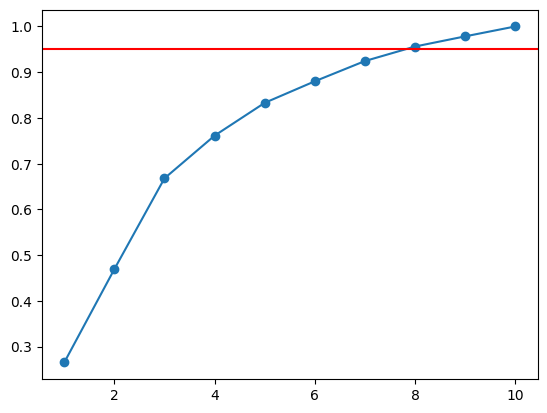

In [132]:
cumulative_variance_ratio=np.cumsum(variance_ratios)
plt.plot(np.arange(1,11),cumulative_variance_ratio,marker='o')
plt.axhline(y=0.95,color='r')

In [133]:
pca = PCA(n_components=8)
pca.fit(df.drop("stroke",axis = 1))

# Get principal components
pcs = pca.transform(df.drop("stroke",axis = 1))
pc_df = pd.DataFrame(pcs, columns=['PC{}'.format(i) for i in range(1, pca.n_components_+1)])

In [134]:
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.435967,-0.400355,0.773850,-0.242334,0.146397,0.216992,0.954659,-0.142243
1,-0.492642,0.593683,0.651570,0.045759,0.038889,0.054032,0.837902,0.373335
2,-0.601204,-0.500241,-0.313742,0.327727,-0.102839,-0.153173,0.085213,-0.320868
3,-0.586136,0.509403,-0.336041,-0.081775,0.910697,-0.313662,-0.132127,-0.144869
4,-0.381775,-0.409631,0.702109,-0.236969,-0.075565,0.110578,0.122814,-0.317613


## Naive Bayes

In [135]:
CNB_clf=ComplementNB().fit(X_train,y_train)
y_pred=CNB_clf.predict(X_test)
print(classification_report(y_test,y_pred,target_names=['not stroke','stroke']))

              precision    recall  f1-score   support

  not stroke       0.97      0.83      0.89      1421
      stroke       0.12      0.46      0.19        74

    accuracy                           0.81      1495
   macro avg       0.54      0.64      0.54      1495
weighted avg       0.93      0.81      0.86      1495



<Axes: >

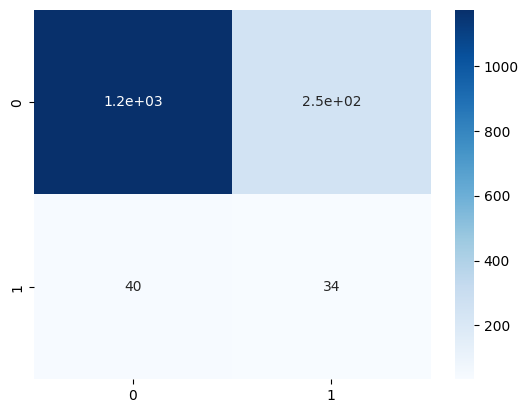

In [136]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='Blues')

## Random Forest Classifier

In [137]:
# RFC_clf=RandomForestClassifier()
# parameters={
#     'n_estimators':[50,100,200],
#     'criterion':['gini','entropy'],
#     'max_depth': [10,50,100],
#     'bootstrap': [True,False]
# }
# clf=RandomizedSearchCV(RFC_clf,parameters,random_state=42)
# search=clf.fit(X_train,y_train)
# best_params=search.best_params_
# print(search.best_params_)

In [138]:
# RFC_clf=RandomForestClassifier(**best_params)
# RFC_clf.fit(X_train,y_train)
# RFC_ypred=RFC_clf.predict(X_test)
# print(RFC_clf.score(X_test,y_test))

In [139]:
# print(classification_report(y_test,RFC_ypred,target_names=['not stroke','stroke']))

In [140]:
# sns.heatmap(confusion_matrix(y_test,RFC_ypred),annot=True,cmap='Blues')

In [141]:
# f1_score(y_test,RFC_ypred)

In [142]:
classifier = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)
print(f1_score(y_test,preds))

0.11320754716981132


In [143]:
def plot_roc_curve(clf,X,y,classes):
    y_probas=clf.predict_proba(X)
    auc_s=[]
    for idx,class_no in enumerate(classes):
        y_true=np.where(y==class_no,1,0)
        y_probs=y_probas[:,idx]
        thresholds=np.sort(y_probs)[::-1]
        tpr=[]
        fpr=[]
        for thres in thresholds:
            y_pred=np.where(y_probs>=thres,1,0)
            tn,fp,fn,tp=confusion_matrix(y_true,y_pred).ravel()
            tpr.append(tp/(tp+fn))
            fpr.append(fp/(fp+tn))
        auc=np.trapz(fpr,tpr)
        auc_s.append(auc)
        plt.plot(tpr,fpr,label=class_no,alpha=0.5,lw=5)
    plt.xlabel('True Positive Rate')
    plt.ylabel('False Positive Rate')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
    print("AUC: ",auc_s)

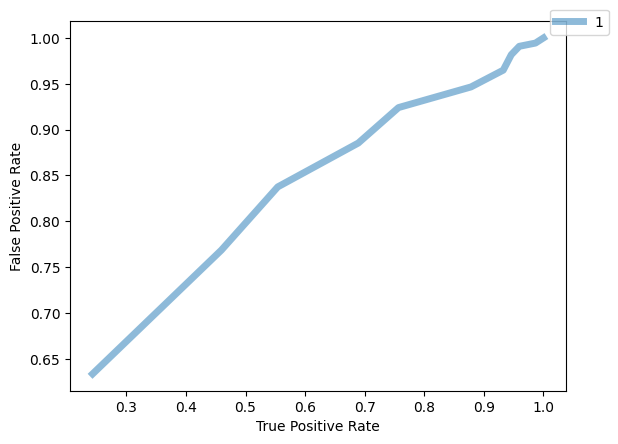

AUC:  [0.6372177948532628]


In [144]:
plot_roc_curve(classifier,X_test,y_test,[1])

In [145]:


# def plot_roc_curve(y_true, y_prob, title=None):
#     """
#     Plots the Receiver Operating Characteristic (ROC) curve for a binary classifier.

#     Parameters:
#     y_true (numpy.ndarray): True labels for the binary classification problem.
#     y_prob (numpy.ndarray): Predicted probabilities for the positive class.
#     title (str, optional): Title for the plot.

#     Returns:
#     None
#     """

#     # Compute the true positive rate (TPR) and false positive rate (FPR) at different probability thresholds.
#     thresholds = np.linspace(0, 1, 100)
#     tprs = []
#     fprs = []
#     for threshold in thresholds:
#         y_pred = (y_prob >= threshold).astype(int)
#         tp = np.sum((y_true == 1) & (y_pred == 1))
#         fp = np.sum((y_true == 0) & (y_pred == 1))
#         tn = np.sum((y_true == 0) & (y_pred == 0))
#         fn = np.sum((y_true == 1) & (y_pred == 0))
#         tpr = tp / (tp + fn)
#         fpr = fp / (fp + tn)
#         tprs.append(tpr)
#         fprs.append(fpr)
#     auc=np.trapz(fprs,tprs)
#     # Plot the ROC curve.
#     plt.plot(fprs, tprs)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     if title is not None:
#         plt.title(title)
#     plt.show()
#     print('Area Under Curve',auc)


In [146]:
y_prob=classifier.predict_proba(X_test)[:,1]
# plot_roc_curve(y_test,y_prob,title='ROC curve')

In [147]:
y_pred=[1 if y_proba>0.4 else 0 for y_proba in y_prob]

In [148]:
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [149]:
best_f1_score=-1
best_thres=-1
for thres in np.arange(0,1,0.01):
    y_pred=[1 if y_proba>0.4 else 0 for y_proba in y_prob]
    score=f1_score(y_test,y_pred)
    if(score>best_f1_score):
        best_f1_score=score
        best_thres=thres
        
print(best_f1_score,best_thres)

0.18 0.0


In [150]:
clf=BaggingClassifier(estimator=SVC(),n_estimators=10,random_state=42).fit(X_train,y_train)
f1_score(clf.predict(X_test),y_test)

0.20785219399538105

In [151]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,0.816895,0.0,1.0,1.0,0.333333,1.0,0.801265,0.647564,0.333333,1
1,1.0,0.975586,0.0,1.0,1.0,0.333333,0.0,0.234512,0.530086,0.666667,1
2,0.0,0.597168,0.0,0.0,1.0,0.333333,1.0,0.536008,0.584527,1.000000,1
3,0.0,0.963379,1.0,0.0,1.0,0.666667,0.0,0.549349,0.286533,0.666667,1
4,1.0,0.987793,0.0,0.0,1.0,0.333333,1.0,0.605161,0.429799,0.333333,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,1.0,0.499512,0.0,0.0,0.0,0.333333,0.0,0.069384,0.452722,0.333333,0
4977,1.0,0.487305,0.0,0.0,1.0,0.333333,1.0,0.627966,0.489971,1.000000,0
4978,0.0,0.548340,1.0,0.0,1.0,0.000000,0.0,0.184194,0.510029,1.000000,0
4979,1.0,0.487305,0.0,0.0,1.0,0.333333,0.0,0.133044,0.458453,1.000000,0


In [152]:
len(np.where(y_train_not_sampled==0)[0])/len(np.where(y_train_not_sampled==1)[0])

19.03448275862069

In [153]:
n_estimators=19
minority_indices=np.where(y_train_not_sampled==1)[0]
majority_indices=np.where(y_train_not_sampled==0)[0]
n=len(minority_indices)
np.random.shuffle(majority_indices)
start=0
end=n+1
voting_ensemble=[]
while(end<len(majority_indices)):
#     print('hi')
    train_data_indices=np.array(minority_indices)
    train_data_indices=np.append(train_data_indices,majority_indices[start:end])
    clf=DecisionTreeClassifier()
    clf.fit(X_train_not_sampled[train_data_indices],y_train_not_sampled[train_data_indices])
    voting_ensemble.append(clf)
    start+=n
    end+=n
train_data_indices=np.array(minority_indices)
train_data_indices=np.append(train_data_indices,majority_indices[start:])
clf=DecisionTreeClassifier()
clf.fit(X_train_not_sampled[train_data_indices],y_train_not_sampled[train_data_indices])
voting_ensemble.append(clf)
    
    
    


In [154]:
temp1=np.array([1,2,3])
temp2=np.array([4,5,6])
temp1=np.append(temp1,temp2)

In [155]:
temp1


array([1, 2, 3, 4, 5, 6])

In [156]:
def pred(voting_ensemble,X_test):
    n=len(voting_ensemble)
    predictions=voting_ensemble[0].predict(X_test)
#     print(predictions[:5])
    for i in range(1,n):
        predictions+=voting_ensemble[i].predict(X_test)
#         print(predictions[:5])
    y_pred=[1 if pred>n/2 else 0 for pred in predictions]
    print(n)
    return y_pred

20


<Axes: >

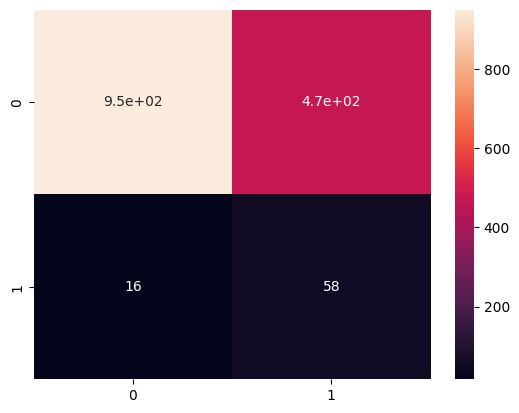

In [157]:
y_pred=pred(voting_ensemble,X_test)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [158]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1421
           1       0.11      0.78      0.19        74

    accuracy                           0.67      1495
   macro avg       0.55      0.73      0.49      1495
weighted avg       0.94      0.67      0.77      1495



In [159]:
accuracy_score(y_test,y_pred)

0.6749163879598662

<Axes: >

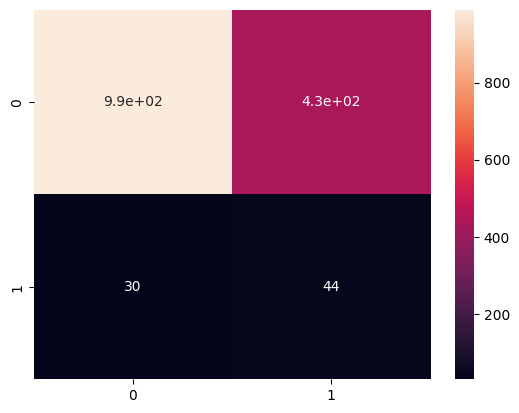

In [160]:
y_pred=voting_ensemble[0].predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [161]:
minority_indices=np.where(y_train_not_sampled==1)[0]
majority_indices=np.where(y_train_not_sampled==0)[0]
indices=np.append(minority_indices,np.random.choice(majority_indices,len(minority_indices)))
temp_X_train=X_train_not_sampled[indices]
temp_y_train=y_train_not_sampled[indices]
clf=SVC(kernel='linear',probability=True).fit(temp_X_train,temp_y_train)
print(confusion_matrix(y_test,clf.predict(X_test)))


[[999 422]
 [ 16  58]]


In [162]:
f1_score(y_test,clf.predict(X_test))

0.20938628158844766

In [163]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1421
           1       0.12      0.78      0.21        74

    accuracy                           0.71      1495
   macro avg       0.55      0.74      0.51      1495
weighted avg       0.94      0.71      0.79      1495



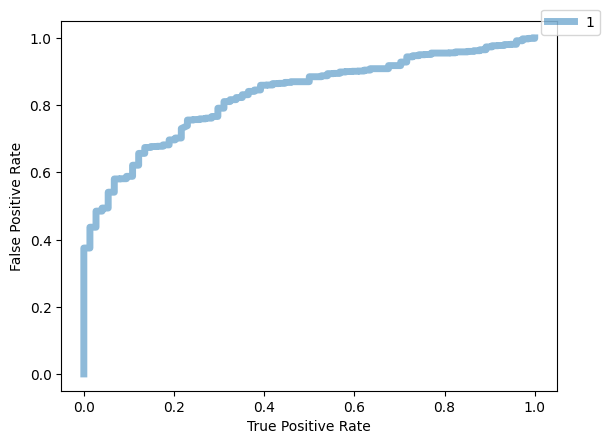

AUC:  [0.8299922019133843]


In [166]:
plot_roc_curve(clf,X_test,y_test,[1])

In [167]:
temp_clf=SVC(kernel='linear').fit(X_train,y_train)

In [168]:
f1_score(y_test,temp_clf.predict(X_test))

0.21468926553672318

In [169]:
clf=MLPClassifier(activation='logistic', alpha=0.5, learning_rate_init=0.01, max_iter=500, solver='adam').fit(X_train,y_train)
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81      1421
           1       0.12      0.80      0.21        74

    accuracy                           0.70      1495
   macro avg       0.55      0.75      0.51      1495
weighted avg       0.94      0.70      0.78      1495



In [170]:
confusion_matrix(y_test,clf.predict(X_test))

array([[987, 434],
       [ 15,  59]], dtype=int64)

In [171]:
knn_clf=KNeighborsClassifier(n_neighbors=40).fit(X_train,y_train)
print(classification_report(y_test,knn_clf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1421
           1       0.11      0.66      0.18        74

    accuracy                           0.71      1495
   macro avg       0.54      0.69      0.50      1495
weighted avg       0.93      0.71      0.79      1495



In [172]:
confusion_matrix(y_test,knn_clf.predict(X_test))

array([[1013,  408],
       [  25,   49]], dtype=int64)

<Axes: xlabel='avg_glucose_level', ylabel='age'>

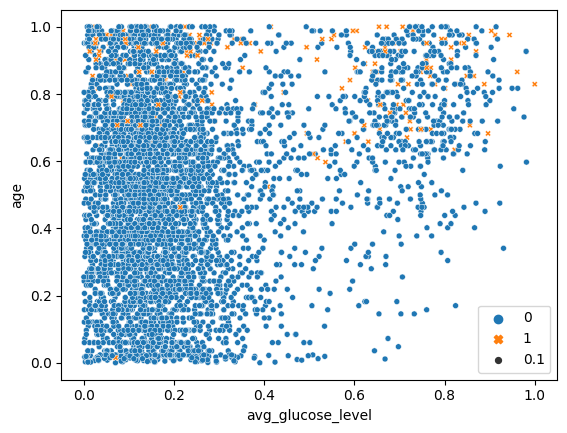

In [173]:
sns.scatterplot(data=df,x=df.columns[7],y=df.columns[1],hue=y,style=y,size=0.1)

In [174]:
xgb_clf=XGBClassifier(objective='binary:logistic',learning_rate=0.001).fit(X_train,y_train)
print(confusion_matrix(y_test,xgb_clf.predict(X_test)))

[[1102  319]
 [  29   45]]


In [175]:
print(classification_report(y_test,xgb_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1421
           1       0.12      0.61      0.21        74

    accuracy                           0.77      1495
   macro avg       0.55      0.69      0.53      1495
weighted avg       0.93      0.77      0.83      1495



In [176]:
best_score=0
best_model=0
for w in range(2,100):
    xgb_clf_custom=XGBClassifier(learning_rate=0.01,scale_pos_weight=w).fit(X_train,y_train)
    score=f1_score(y_test,xgb_clf_custom.predict(X_test))
    if(score>best_score):
        best_score=score
        best_model=xgb_clf_custom

In [177]:
print(classification_report(y_test,xgb_clf_custom.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.49      0.66      1421
           1       0.08      0.88      0.15        74

    accuracy                           0.51      1495
   macro avg       0.54      0.69      0.40      1495
weighted avg       0.94      0.51      0.63      1495



In [178]:
best_score

0.2061855670103093

In [179]:
print(classification_report(y_test,best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1421
           1       0.12      0.68      0.21        74

    accuracy                           0.74      1495
   macro avg       0.55      0.71      0.53      1495
weighted avg       0.94      0.74      0.81      1495



In [180]:
confusion_matrix(y_test,best_model.predict(X_test))

array([[1060,  361],
       [  24,   50]], dtype=int64)

In [181]:
classifier = LogisticRegressionCV(cv=5, random_state = 0, max_iter=1000)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)

In [182]:
confusion_matrix(y_test,classifier.predict(X_test))


array([[1048,  373],
       [  17,   57]], dtype=int64)

In [183]:
print(classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1421
           1       0.13      0.77      0.23        74

    accuracy                           0.74      1495
   macro avg       0.56      0.75      0.53      1495
weighted avg       0.94      0.74      0.81      1495



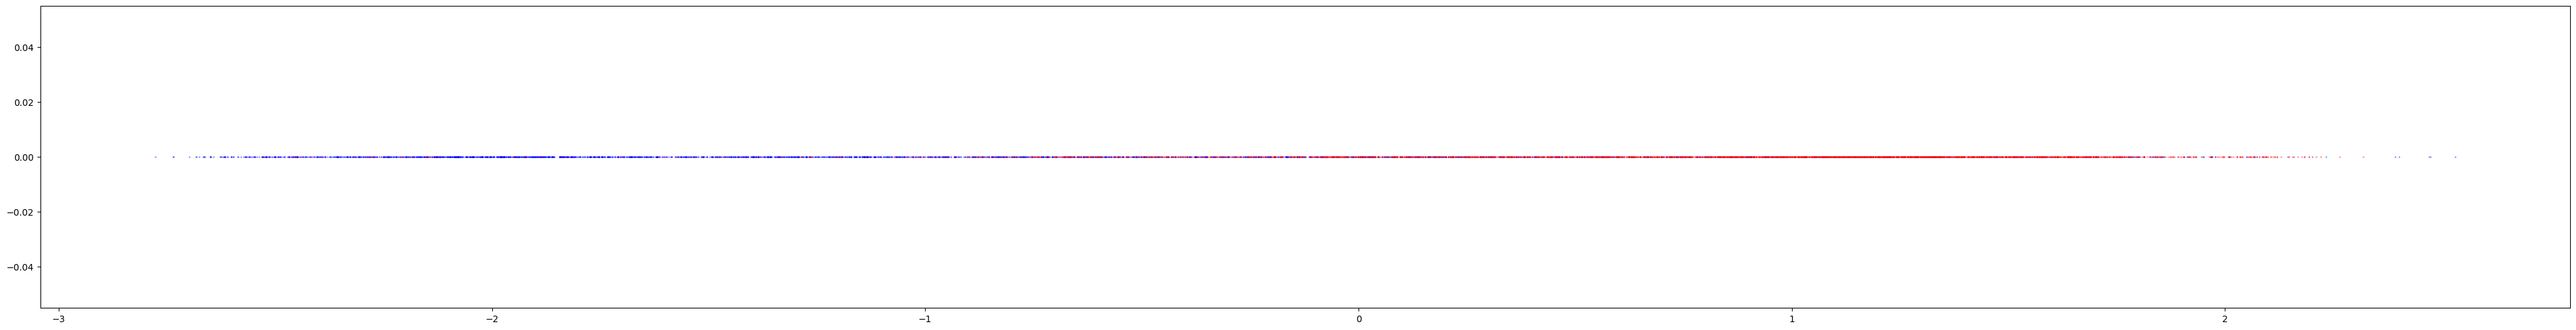

In [184]:

lda=LDA(n_components=1)
lda.fit(X_train,y_train)
X_train_lda=lda.transform(X_train)
plt.figure(figsize=(50,6))
idx=np.where(y_train==0)[0]
plt.scatter(X_train_lda[idx],np.zeros(len(idx)),c='b',s=0.1)
idx=np.where(y_train==1)[0]
plt.scatter(X_train_lda[idx],np.zeros(len(idx)),c='r',s=0.1)


In [185]:
y_pred=lda.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[1034,  387],
       [  17,   57]], dtype=int64)

In [186]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1421
           1       0.13      0.77      0.22        74

    accuracy                           0.73      1495
   macro avg       0.56      0.75      0.53      1495
weighted avg       0.94      0.73      0.81      1495



In [187]:
classifier = LogisticRegressionCV(cv=5, random_state = 0, max_iter=1000)
classifier.fit(X_train_lda, y_train.ravel())
y_pred = classifier.predict(lda.transform(X_test))

In [188]:
confusion_matrix(y_test,y_pred)

array([[1067,  354],
       [  17,   57]], dtype=int64)

In [189]:
classifier = SVC(kernel='linear',C=50)
classifier.fit(X_train_lda, y_train.ravel())
y_pred = classifier.predict(lda.transform(X_test))

In [190]:
confusion_matrix(y_test,y_pred)

array([[1036,  385],
       [  17,   57]], dtype=int64)

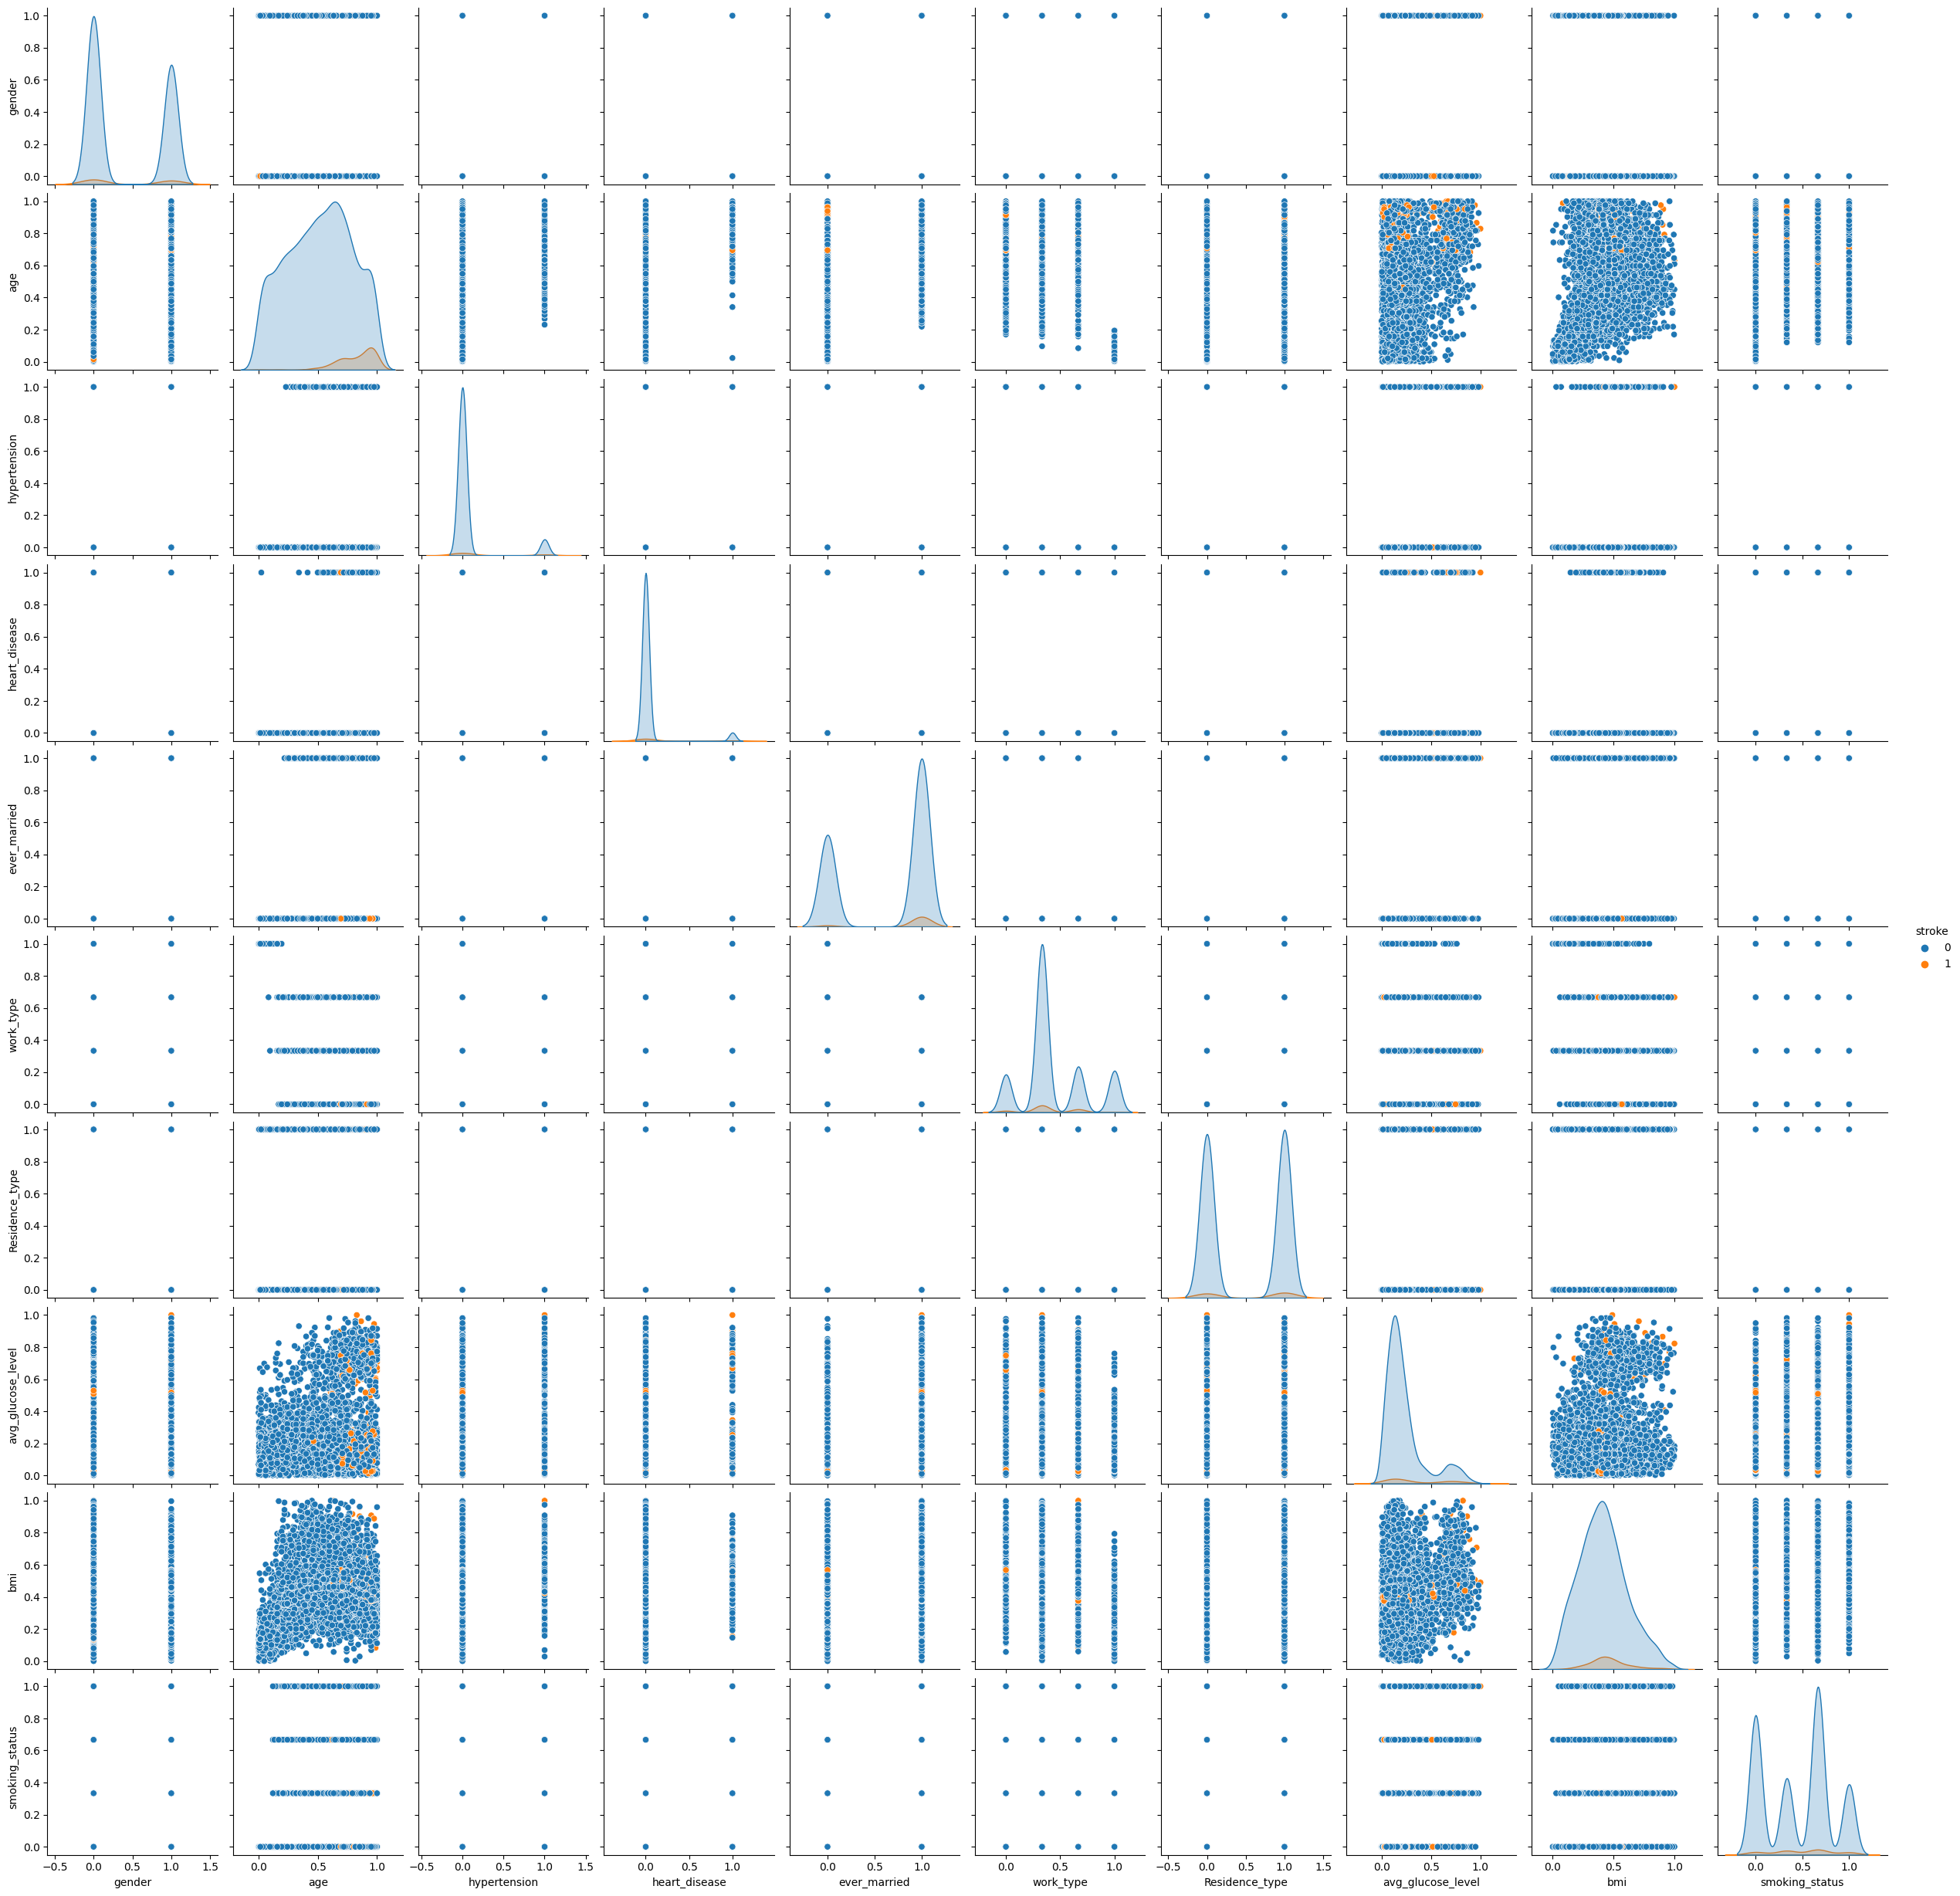

In [192]:
sns.pairplot(df,hue='stroke')